<a href="https://colab.research.google.com/github/VisageDvachevsky/Dano2024/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import kstest, norm, wilcoxon, mannwhitneyu, f_oneway, ks_2samp
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [192]:
data = pd.read_csv('https://github.com/VisageDvachevsky/Dano2024/raw/refs/heads/main/data/dano.csv')

<ipython-input-192-683c7a90740c>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('https://github.com/VisageDvachevsky/Dano2024/raw/refs/heads/main/data/dano.csv')


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97307 entries, 0 to 97306
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 97307 non-null  int64  
 1   region                     97306 non-null  object 
 2   offenceshortstatement      97306 non-null  object 
 3   offencedate                97306 non-null  object 
 4   offencetime                97306 non-null  object 
 5   engine_type                97306 non-null  object 
 6   engine_power               97300 non-null  float64
 7   auto_mark                  97306 non-null  object 
 8   auto_year                  97305 non-null  float64
 9   auto_model                 97306 non-null  object 
 10  color                      97306 non-null  object 
 11  gear_type                  97306 non-null  object 
 12  car_price                  90868 non-null  float64
 13  gender_cd                  97182 non-null  obj

In [21]:
data.head()

,Unnamed: 0,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,...,gear_type,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
0,0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,...,Автоматическая,712.0,True,23.0,UNM,0.0,UGR,80.0,Среда,False
1,1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,...,Механическая,162.0,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False
2,2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,...,Автоматическая,2601.0,True,43.0,NaN,NaN,NaN,500.0,Пятница,True
3,3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,...,Механическая,410.0,True,27.0,UNM,0.0,SCH,35.0,Четверг,False
4,4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,...,Автоматическая,617.0,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True


In [193]:
data.children_cnt.fillna(data.children_cnt.median(), inplace=True)

In [194]:
data.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [24]:
data.describe()

,engine_power,auto_year,car_price,age,children_cnt,person_monthly_income_amt
count,97300.000000,97305.000000,90868.000000,97298.000000,97307.000000,8.383200e+04
mean,161.533349,2013.258466,1615.316140,37.610177,0.139712,1.054343e+04
std,79.591023,6.135792,1674.055564,10.598194,0.501735,3.001781e+06
min,0.000000,1910.000000,46.000000,4.000000,0.000000,0.000000e+00
25%,107.000000,2009.000000,628.000000,30.000000,0.000000,7.000000e+01
50%,145.000000,2013.000000,1105.000000,37.000000,0.000000,1.150000e+02
75%,190.000000,2018.000000,2045.000000,44.000000,0.000000,2.000000e+02
max,1770.000000,2024.000000,35470.000000,88.000000,9.000000,8.691286e+08


In [195]:


marital_status_map = {0: 'CIV', 1: 'MAR', 2: 'DIV', 3: 'DILW', 4: 'UNM', 5: 'WID'}
education_level_map = {0: 'SCH', 1: 'UGR', 2: 'GRD', 3: 'PGR', 4: 'ACD', 5: 'MGR', 6: 'AGR', 7: 'SPC'}
columns_to_impute = ['marital_status_cd', 'education_level_cd']

df = data
dataa = df.copy()

numeric_columns = ['age', 'car_price', 'person_monthly_income_amt', 'children_cnt']
predictors = numeric_columns + columns_to_impute

for col in columns_to_impute:
    dataa[col] = dataa[col].astype(str)
    dataa[col] = np.where(dataa[col] == 'nan', np.nan, dataa[col])
    le = LabelEncoder()
    dataa[col] = le.fit_transform(dataa[col].astype(str))

filtered_data = dataa[predictors]
imputer = KNNImputer(n_neighbors=5)


imputed_data = imputer.fit_transform(filtered_data)

imputed_df = pd.DataFrame(imputed_data, columns=predictors)

imputed_df['marital_status_cd'] = imputed_df['marital_status_cd'].round().astype(int)
imputed_df['education_level_cd'] = imputed_df['education_level_cd'].round().astype(int)

imputed_df['marital_status_cd'] = imputed_df['marital_status_cd'].map(marital_status_map)
imputed_df['education_level_cd'] = imputed_df['education_level_cd'].map(education_level_map)

df['marital_status_cd'] = imputed_df['marital_status_cd']
df['education_level_cd'] = imputed_df['education_level_cd']

print(df.head())


                region              offenceshortstatement offencedate  \
0               Москва                Движение по обочине  2024-05-15   
1  Воронежская область  Превышение скорости на 40-60 км/ч  2024-05-13   
2          Севастополь  Превышение скорости на 20-40 км/ч  2024-05-10   
3      Республика Тыва  Превышение скорости на 20-40 км/ч  2024-05-02   
4  Воронежская область  Превышение скорости на 20-40 км/ч  2024-04-28   

  offencetime engine_type  engine_power   auto_mark  auto_year    auto_model  \
0    09:52:48        1.8          152.0       SKODA     2011.0       OCTAVIA   
1    17:54:58        1.6           73.0  LADA (ВАЗ)     2011.0          2107   
2    00:29:11        2.5          145.0     HYUNDAI     2018.0  GRAND STAREX   
3    21:44:46        2.0          150.0  MITSUBISHI     2007.0        LANCER   
4    16:25:51        2.3          155.0        FORD     2004.0        ESCAPE   

     color       gear_type  car_price gender_cd   age marital_status_cd  \
0   Ч

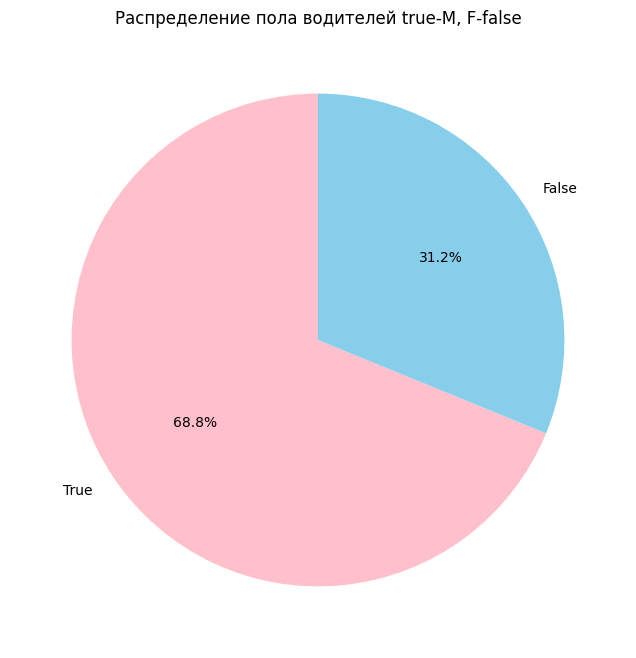

In [26]:
plt.figure(figsize=(8, 8))
plt.pie(data['gender_cd'].value_counts(), labels=data['gender_cd'].value_counts().index,
         autopct='%1.1f%%', colors=['pink','skyblue'], startangle=90)
plt.title('Распределение пола водителей true-M, F-false');

<ipython-input-27-86bf748ce98a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=data, palette='viridis', hue=None, legend=False)


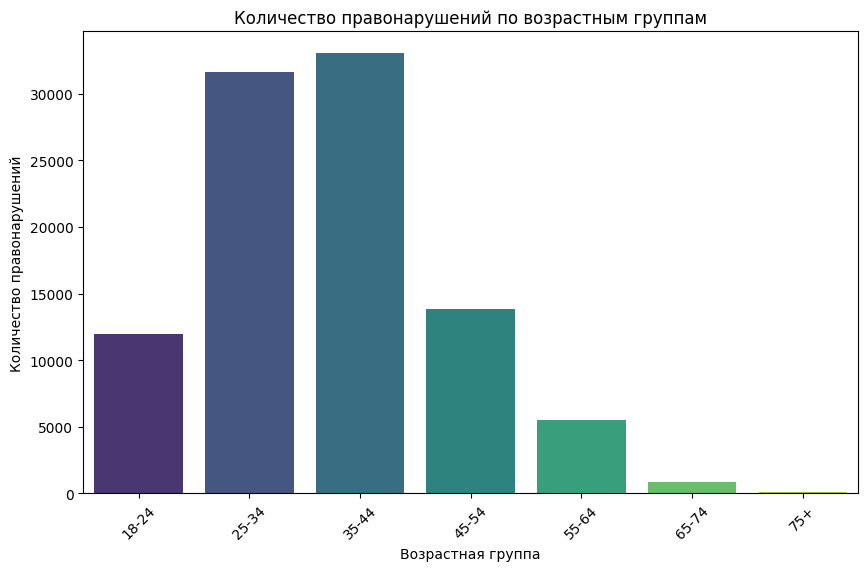

In [27]:
age_bins = [18, 25, 35, 45, 55, 65, 75, 85]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)

plt.figure(figsize=(10, 6))
age_group_counts = data['age_group'].value_counts().sort_index()
sns.countplot(x='age_group', data=data, palette='viridis', hue=None, legend=False)
plt.title('Количество правонарушений по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество правонарушений')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-36c6cc71b4e4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=data, palette='muted', hue=None, legend=False)


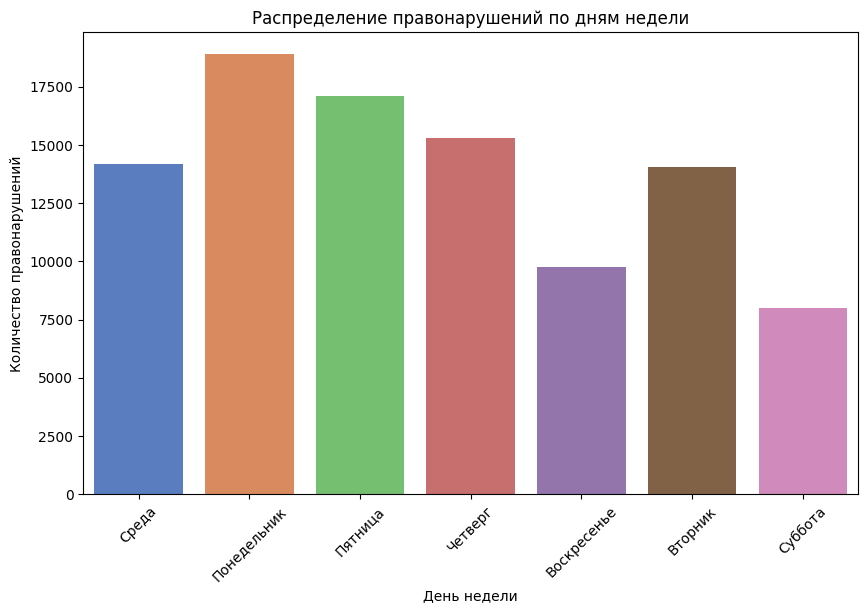

In [ ]:
plt.figure(figsize=(10, 6))
day_of_week_counts = data['day_of_week'].value_counts().sort_index()
sns.countplot(x='day_of_week', data=data, palette='muted', hue=None, legend=False)
plt.title('Распределение правонарушений по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество правонарушений')
plt.xticks(rotation=45);

In [85]:
data.select_dtypes(include=[int, float]).corr()

,engine_power,auto_year,car_price,age,children_cnt,person_monthly_income_amt
engine_power,1.000000,0.156908,0.594216,0.048522,0.004068,0.002557
auto_year,0.156908,1.000000,0.532356,0.131454,0.032672,-0.005645
car_price,0.594216,0.532356,1.000000,0.105526,0.007656,-0.000866
age,0.048522,0.131454,0.105526,1.000000,0.118175,0.004075
children_cnt,0.004068,0.032672,0.007656,0.118175,1.000000,-0.001001
person_monthly_income_amt,0.002557,-0.005645,-0.000866,0.004075,-0.001001,1.000000


In [198]:
data['engine_type'] = pd.to_numeric(data['engine_type'], errors='coerce')
data.dropna(subset=['engine_type'], inplace=True)

In [87]:
data.engine_type.astype(float)

,engine_type
0,1.8
1,1.6
2,2.5
3,2.0
4,2.3
...,...
97302,2.5
97303,1.6
97304,1.6
97305,2.0


In [ ]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,712.0,True,23.0,UNM,0.0,UGR,80.0,Среда,False,18-24
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,162.0,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False,18-24
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,2601.0,True,43.0,NaN,0.0,NaN,500.0,Пятница,True,35-44
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,410.0,True,27.0,UNM,0.0,SCH,35.0,Четверг,False,25-34
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,617.0,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True,35-44


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97300 entries, 0 to 97306
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     97300 non-null  object 
 1   offenceshortstatement      97300 non-null  object 
 2   offencedate                97300 non-null  object 
 3   offencetime                97300 non-null  object 
 4   engine_type                97300 non-null  float64
 5   engine_power               97299 non-null  float64
 6   auto_mark                  97300 non-null  object 
 7   auto_year                  97299 non-null  float64
 8   auto_model                 97300 non-null  object 
 9   color                      97300 non-null  object 
 10  gear_type                  97300 non-null  object 
 11  car_price                  90862 non-null  float64
 12  gender_cd                  97176 non-null  object 
 13  age                        97292 non-null  float64


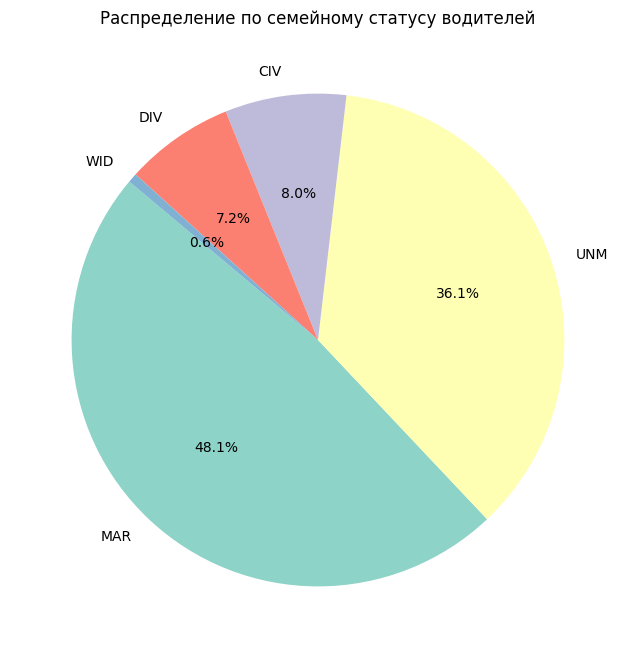

In [ ]:
plt.figure(figsize=(8, 8))
marital_status_counts = data['marital_status_cd'].value_counts()
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set3'), startangle=140)
plt.title('Распределение по семейному статусу водителей');

<ipython-input-22-29bda1381a8f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_auto_marks.index, y=top10_auto_marks.values, palette='tab10', hue=None, legend=False)


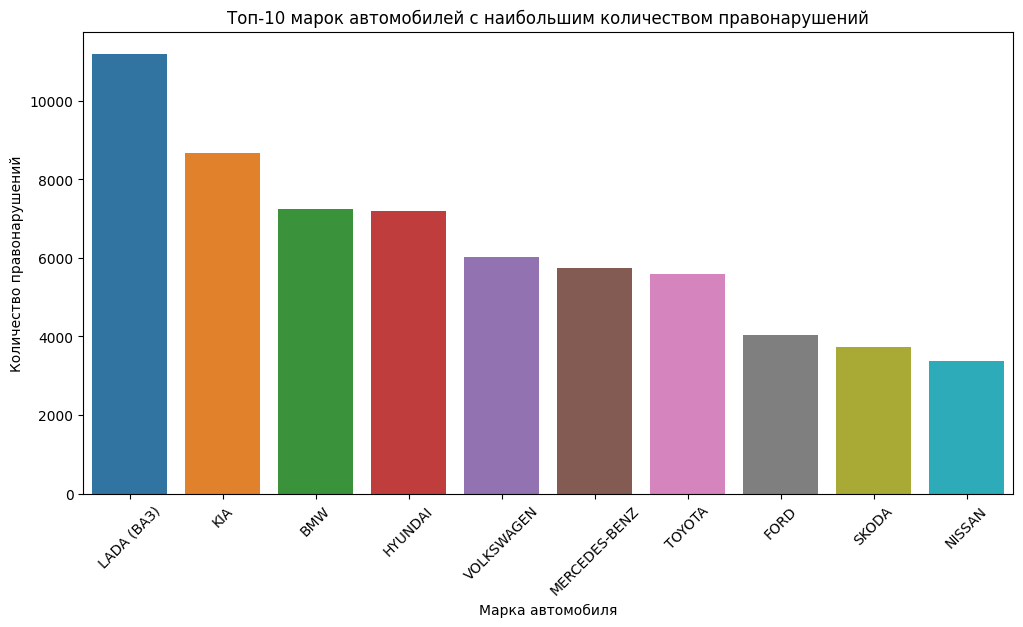

In [ ]:
top10_auto_marks = data['auto_mark'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_auto_marks.index, y=top10_auto_marks.values, palette='tab10', hue=None, legend=False)
plt.title('Топ-10 марок автомобилей с наибольшим количеством правонарушений')
plt.xlabel('Марка автомобиля')
plt.ylabel('Количество правонарушений')
plt.xticks(rotation=45);

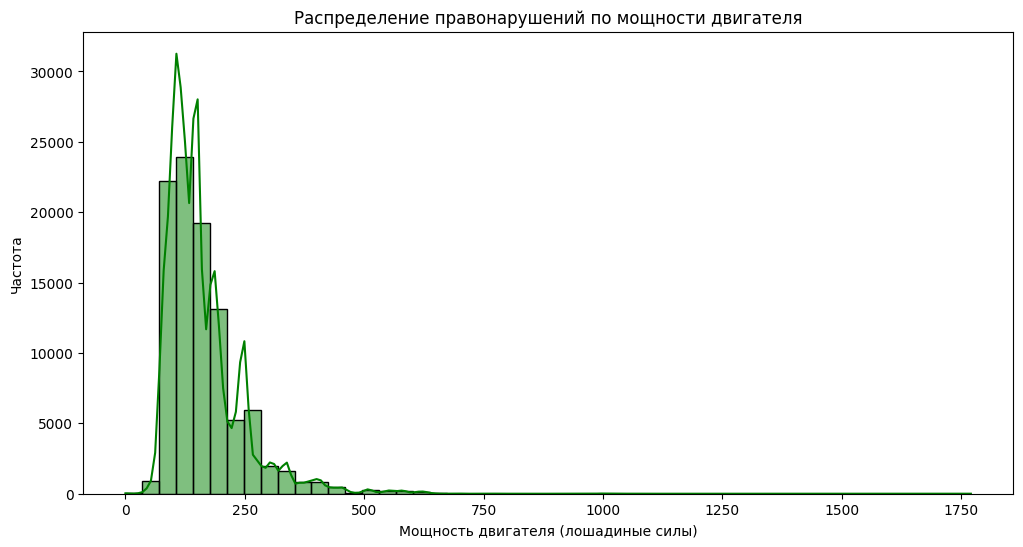

In [ ]:
plt.figure(figsize=(12, 6))
data['engine_power'] = pd.to_numeric(data['engine_power'], errors='coerce')
sns.histplot(data['engine_power'], bins=50, kde=True, color='green')
plt.title('Распределение правонарушений по мощности двигателя')
plt.xlabel('Мощность двигателя (лошадиные силы)')
plt.ylabel('Частота');

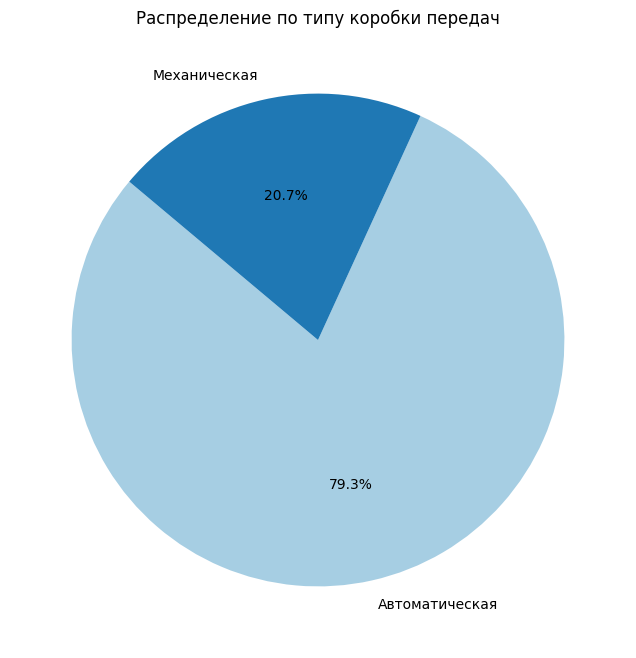

In [ ]:
plt.figure(figsize=(8, 8))
gear_type_counts = data['gear_type'].value_counts()
plt.pie(gear_type_counts, labels=gear_type_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Paired'), startangle=140)
plt.title('Распределение по типу коробки передач');

машины с мощными двигателями чаще нарушают пдд

In [ ]:
data['offence_datetime'] = data.offencedate + ' ' + data.offencetime

In [95]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,gear_type,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,Автоматическая,712.0,True,23.0,DILW,0.0,MGR,80.0,Среда,False
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,Механическая,162.0,True,19.0,WID,0.0,AGR,45.0,Понедельник,False
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,Автоматическая,2601.0,True,43.0,WID,0.0,AGR,500.0,Пятница,True
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,Механическая,410.0,True,27.0,DILW,0.0,ACD,35.0,Четверг,False
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,Автоматическая,617.0,False,42.0,DIV,0.0,GRD,50.0,Воскресенье,True


In [90]:
data['offence_datetime'] = pd.to_datetime(data['offence_datetime'])

KeyError: 'offence_datetime'

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97300 entries, 0 to 97306
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     97300 non-null  object 
 1   offenceshortstatement      97300 non-null  object 
 2   offencedate                97300 non-null  object 
 3   offencetime                97300 non-null  object 
 4   engine_type                97300 non-null  float64
 5   engine_power               97299 non-null  float64
 6   auto_mark                  97300 non-null  object 
 7   auto_year                  97299 non-null  float64
 8   auto_model                 97300 non-null  object 
 9   color                      97300 non-null  object 
 10  gear_type                  97300 non-null  object 
 11  car_price                  90862 non-null  float64
 12  gender_cd                  97176 non-null  object 
 13  age                        97292 non-null  float64


In [197]:
data.groupby(data['offence_datetime'].dt.to_period('M')).count()

KeyError: 'offence_datetime'

In [199]:
data.drop(data[data['person_monthly_income_amt']==869128596.0].index, inplace=True)

In [200]:
data.drop(data[data['education_level_cd']==';'].index, inplace=True)

In [201]:
data.groupby('gender_cd').count()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,gear_type,car_price,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
gender_cd,,,,,,,,,,,,,,,,,,,
False,30302,30302,30302,30302,30302,30302,30302,30301,30302,30302,30302,28906,30298,30302,30302,30302,25714,30302,30302
True,66873,66873,66873,66873,66873,66872,66873,66873,66873,66873,66873,61841,66869,66873,66873,66873,58067,66873,66873


In [202]:
data.groupby('auto_mark').count()['region'].nlargest(10)

,region
auto_mark,
LADA (ВАЗ),11196
KIA,8655
BMW,7248
HYUNDAI,7198
VOLKSWAGEN,6026
MERCEDES-BENZ,5746
TOYOTA,5591
FORD,4027
SKODA,3731


In [203]:
data.groupby('auto_mark').count()['region'].nsmallest(10)

,region
auto_mark,
172411,1
274700,1
2790000001002,1
ASTON MARTIN,1
BOGDAN,1
BUICK,1
CUPRA,1
DACIA,1
DACIA LODGY,1


In [204]:
data.groupby('color').count()['region'].nlargest(10)

,region
color,
БЕЛЫЙ,25083
ЧЕРНЫЙ,24068
СЕРЫЙ,10766
СИНИЙ,7819
КРАСНЫЙ,4262
КОРИЧНЕВЫЙ,4143
СЕРЕБРИСТЫЙ,3156
ЗЕЛЕНЫЙ,2148
ЖЕЛТЫЙ,1750


In [205]:
data.groupby('auto_year').count()['region'].nlargest(10)

,region
auto_year,
2012.0,6974
2019.0,6689
2013.0,6519
2018.0,6381
2008.0,6335
2011.0,6090
2014.0,5722
2021.0,5590
2017.0,5105


(1980.0, 2029.7)

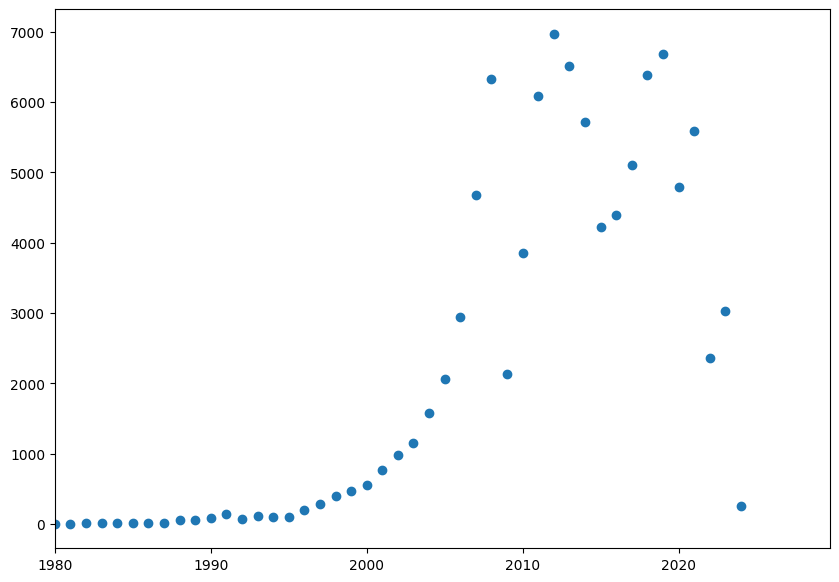

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x=data.groupby('auto_year').count().index, y=data.groupby('auto_year').count()['region'])
plt.xlim(1980)

гипотеза 1 - чем новее машины, тем больше нарушений

In [206]:
auto_to_pdd = data.groupby('auto_year').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

In [101]:
auto_to_pdd.corr()

,auto_year,count_pdd
auto_year,1.000000,0.619284
count_pdd,0.619284,1.000000


In [ ]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group,offence_datetime
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,True,23.0,UNM,0.0,UGR,80.0,Среда,False,18-24,2024-05-15 09:52:48
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False,18-24,2024-05-13 17:54:58
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,True,43.0,NaN,0.0,NaN,500.0,Пятница,True,35-44,2024-05-10 00:29:11
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,True,27.0,UNM,0.0,SCH,35.0,Четверг,False,25-34,2024-05-02 21:44:46
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True,35-44,2024-04-28 16:25:51


In [ ]:
data.groupby('car_price').count()['region'].reset_index().rename(columns={'region': 'count_pdd'}).corr()

Text(0.5, 0, 'car_price')

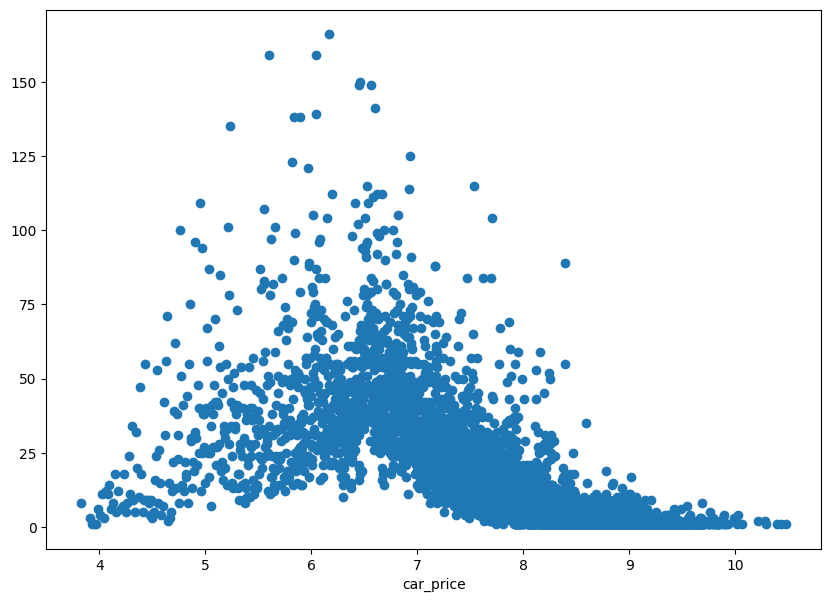

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x=np.log(data.groupby('car_price').count().index), y=data.groupby('car_price').count()['region'])
plt.xlabel('car_price')

Text(0.5, 0, 'car_price')

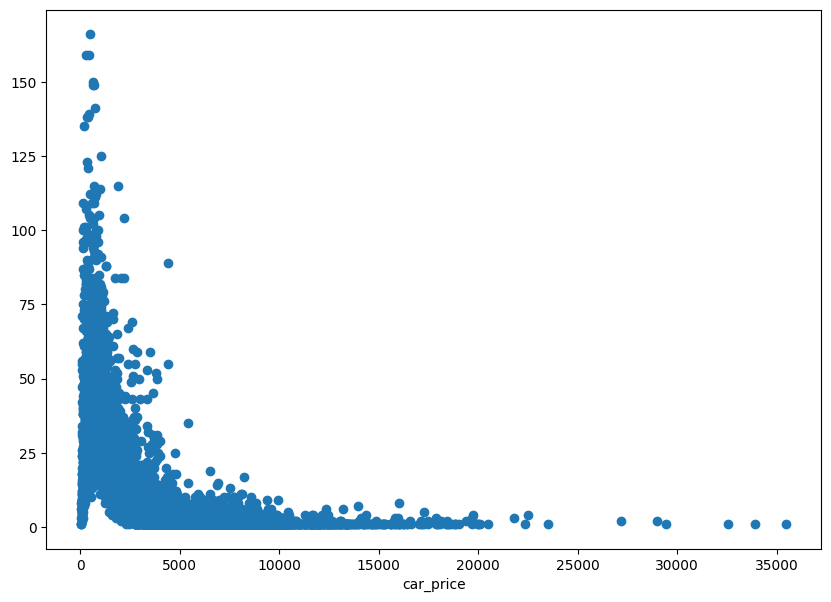

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x=data.groupby('car_price').count().index, y=data.groupby('car_price').count()['region'])
plt.xlabel('car_price')

In [ ]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group,offence_datetime
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,True,23.0,UNM,0.0,UGR,80.0,Среда,False,18-24,2024-05-15 09:52:48
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False,18-24,2024-05-13 17:54:58
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,True,43.0,NaN,0.0,NaN,500.0,Пятница,True,35-44,2024-05-10 00:29:11
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,True,27.0,UNM,0.0,SCH,35.0,Четверг,False,25-34,2024-05-02 21:44:46
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True,35-44,2024-04-28 16:25:51


In [ ]:
data.columns

Index(['region', 'offenceshortstatement', 'offencedate', 'offencetime',
       'engine_type', 'engine_power', 'auto_mark', 'auto_year', 'auto_model',
       'color', 'gear_type', 'car_price', 'gender_cd', 'age',
       'marital_status_cd', 'children_cnt', 'education_level_cd',
       'person_monthly_income_amt', 'day_of_week', 'public_holiday',
       'age_group', 'offence_datetime'],
      dtype='object')

In [207]:
data.groupby('age').count()['region'].reset_index().rename(columns={'region': 'count_pdd'}).corr()

,age,count_pdd
age,1.000000,-0.695182
count_pdd,-0.695182,1.000000


In [208]:
data.groupby('marital_status_cd').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,marital_status_cd,count_pdd
0,CIV,5994
1,DILW,27213
2,DIV,36278
3,MAR,5396
4,UNM,465
5,WID,21953


In [209]:
data.groupby('public_holiday').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,public_holiday,count_pdd
0,False,72874
1,True,24425


In [210]:
data.groupby('day_of_week').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,day_of_week,count_pdd
0,Воскресенье,9750
1,Вторник,14064
2,Понедельник,18894
3,Пятница,17084
4,Среда,14191
5,Суббота,8010
6,Четверг,15306


гипотеза 2 - пдд больше нарушают в рабочие дни (может быть связана с потоком, который в рабочие дни выше)

In [211]:
data.groupby('public_holiday').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,public_holiday,count_pdd
0,False,72874
1,True,24425


In [ ]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group,offence_datetime
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,True,23.0,UNM,0.0,UGR,80.0,Среда,False,18-24,2024-05-15 09:52:48
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False,18-24,2024-05-13 17:54:58
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,True,43.0,NaN,0.0,NaN,500.0,Пятница,True,35-44,2024-05-10 00:29:11
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,True,27.0,UNM,0.0,SCH,35.0,Четверг,False,25-34,2024-05-02 21:44:46
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True,35-44,2024-04-28 16:25:51


In [108]:
data.groupby(data['offence_datetime'].dt.hour)['region'].count().reset_index()

KeyError: 'offence_datetime'

In [109]:
date_pddcount = data.groupby(data['offence_datetime'].dt.hour)['region'].count().reset_index()

KeyError: 'offence_datetime'

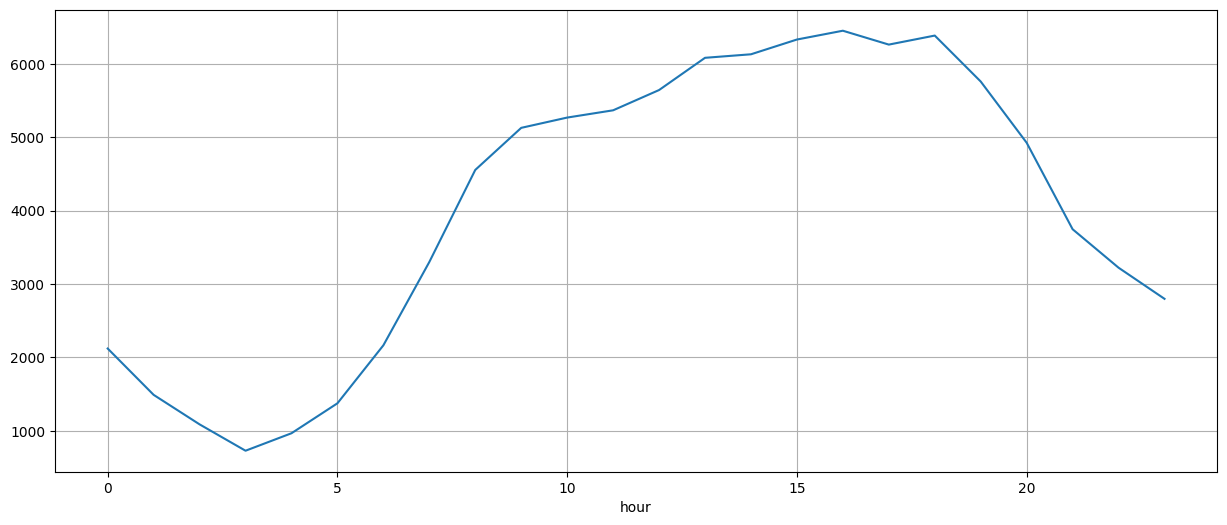

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(date_pddcount['region'])
plt.xlabel('hour')
plt.grid();

гипотеза 3 ночью нарушений меньше, чем днем

In [110]:
date_pddcount_work_day = data[data['public_holiday']==False].groupby(data['offence_datetime'].dt.hour)['region'].count().reset_index() #рабочие дни

KeyError: 'offence_datetime'

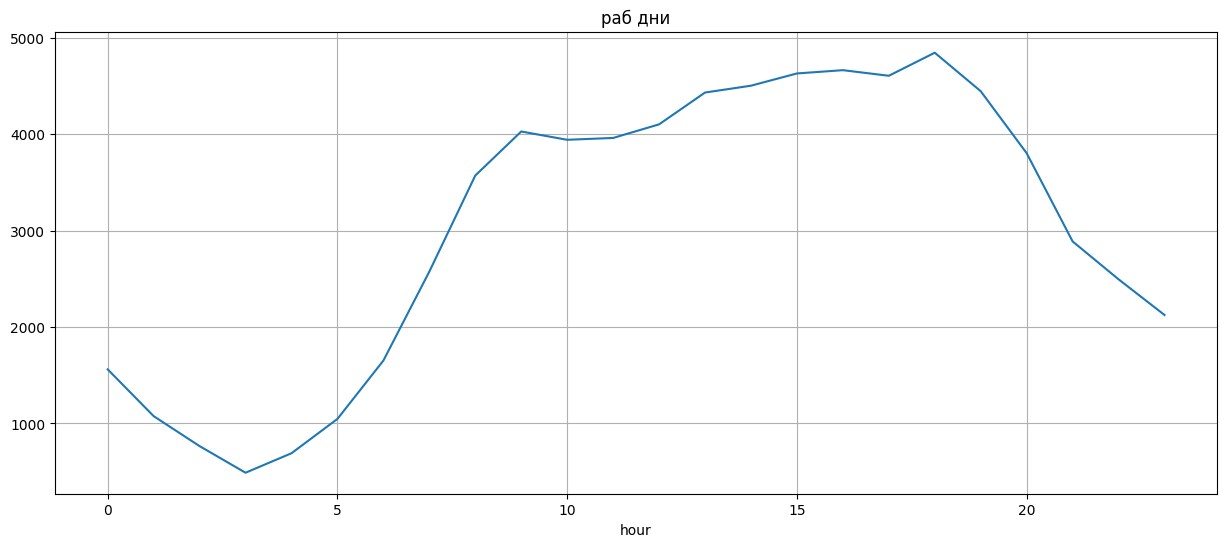

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(date_pddcount_work_day['region'])
plt.xlabel('hour')
plt.title('раб дни')
plt.grid();

In [111]:
date_pddcount_dont_work_day = data[data['public_holiday']==True].groupby(data['offence_datetime'].dt.hour)['region'].count().reset_index() #не рабочие дни

KeyError: 'offence_datetime'

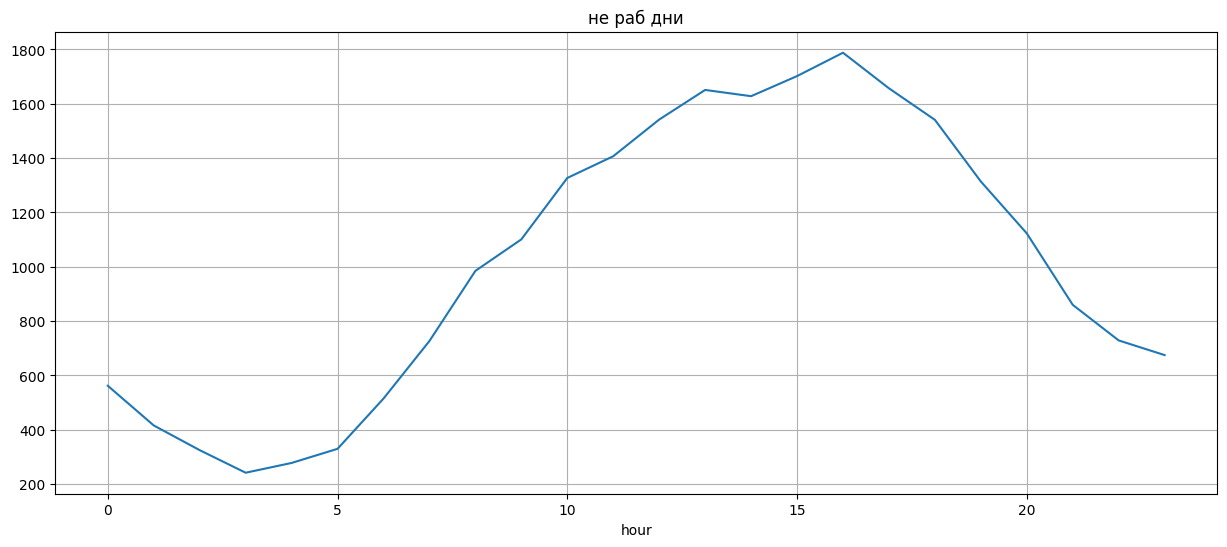

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(date_pddcount_dont_work_day['region'])
plt.xlabel('hour')
plt.title('не раб дни')
plt.grid();

In [ ]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group,offence_datetime
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,True,23.0,UNM,0.0,UGR,80.0,Среда,False,18-24,2024-05-15 09:52:48
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,True,19.0,NaN,0.0,NaN,45.0,Понедельник,False,18-24,2024-05-13 17:54:58
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,True,43.0,NaN,0.0,NaN,500.0,Пятница,True,35-44,2024-05-10 00:29:11
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,True,27.0,UNM,0.0,SCH,35.0,Четверг,False,25-34,2024-05-02 21:44:46
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,False,42.0,MAR,0.0,GRD,50.0,Воскресенье,True,35-44,2024-04-28 16:25:51


In [212]:
  data.groupby('children_cnt').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,children_cnt,count_pdd
0,0.0,88726
1,1.0,4612
2,2.0,3110
3,3.0,704
4,4.0,111
5,5.0,21
6,6.0,7
7,7.0,5
8,8.0,2
9,9.0,1


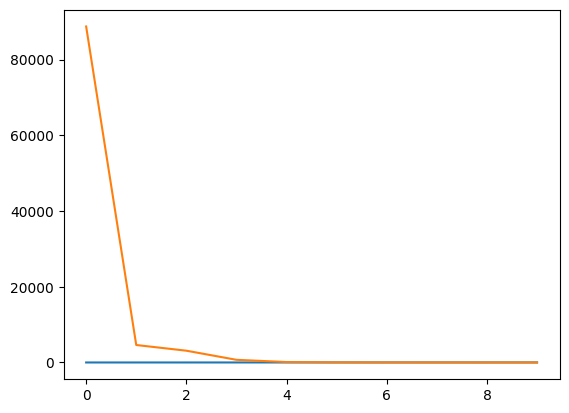

In [213]:
children_pdd = data.groupby('children_cnt').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})
plt.plot(children_pdd)

гипотеза 4 чем меньше детей, тем больше нарушений

In [114]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,gear_type,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,Автоматическая,712.0,True,23.0,DILW,0.0,MGR,80.0,Среда,False
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,Механическая,162.0,True,19.0,WID,0.0,AGR,45.0,Понедельник,False
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,Автоматическая,2601.0,True,43.0,WID,0.0,AGR,500.0,Пятница,True
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,Механическая,410.0,True,27.0,DILW,0.0,ACD,35.0,Четверг,False
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,Автоматическая,617.0,False,42.0,DIV,0.0,GRD,50.0,Воскресенье,True


In [214]:
data.groupby('gear_type').count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

,gear_type,count_pdd
0,Автоматическая,77144
1,Механическая,20155


TypeError: unhashable type: 'numpy.ndarray'

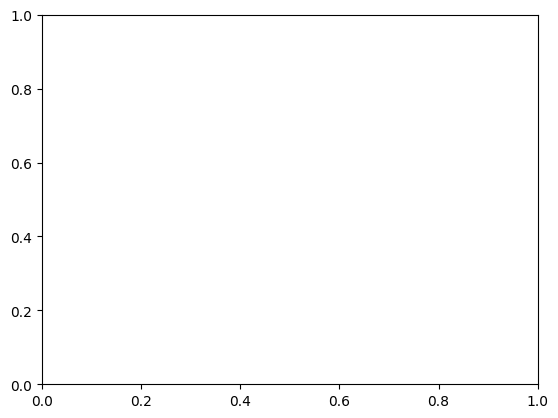

In [215]:
plt.plot(data.groupby('gear_type').count()['region'].reset_index().rename(columns={'region': 'count_pdd'}))

гипотеза 5 с автоматической коробкой передач уровень нарушений больше, чем с механической

In [247]:
people_with_9_children = data[data['children_cnt'] == 9]
if not people_with_9_children.empty:
    print(f"Количество людей с 9 детьми: {len(people_with_9_children)}")
else:
    print("В датафрейме нет людей с 9 детьми.")

Количество людей с 9 детьми: 1


In [216]:
child_age_pdd = data.groupby(['children_cnt', 'age']).count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

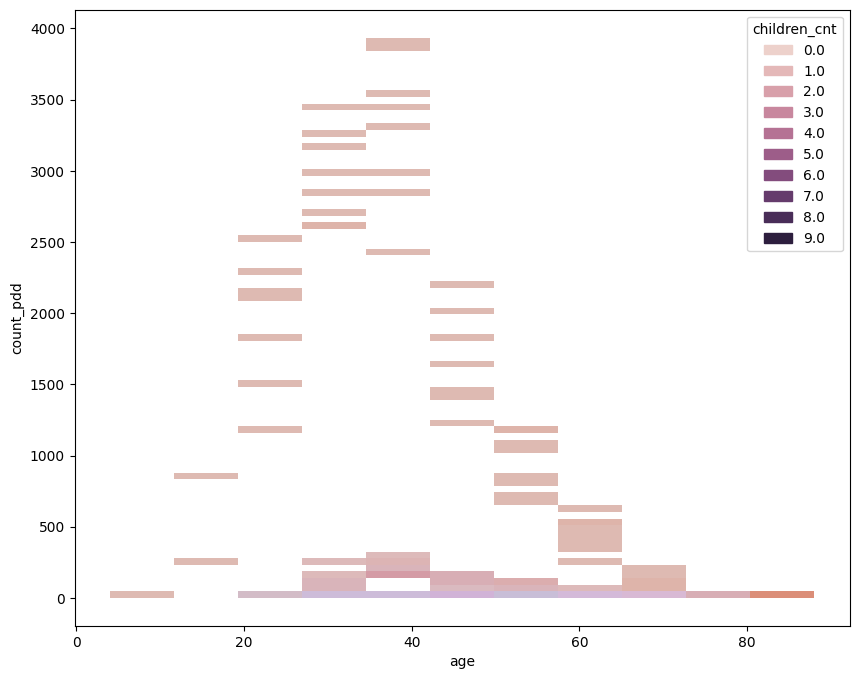

In [217]:
plt.figure(figsize=(10, 8))
sns.histplot(child_age_pdd, x='age', y='count_pdd', hue='children_cnt', multiple='stack');

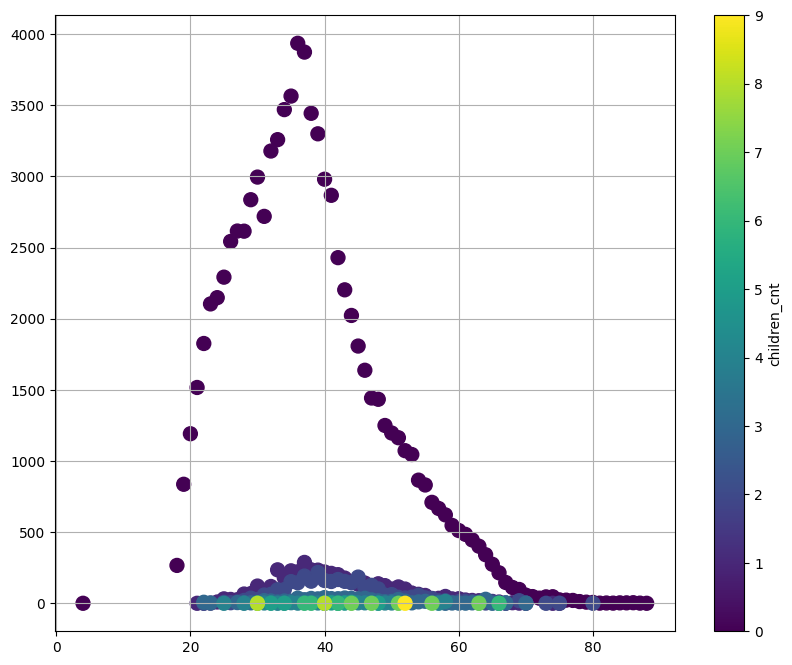

In [218]:
plt.figure(figsize=(10, 8))
scatter=plt.scatter(child_age_pdd['age'], child_age_pdd['count_pdd'], c=child_age_pdd['children_cnt'], cmap='viridis', s=100)
plt.grid()
plt.colorbar(scatter, label='children_cnt');

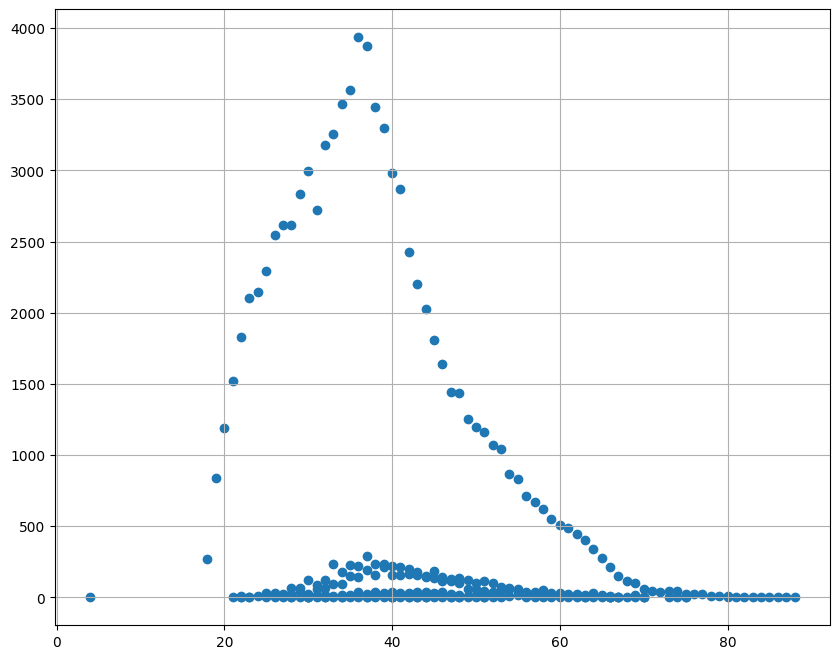

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(child_age_pdd['age'], child_age_pdd['count_pdd'])
plt.grid();

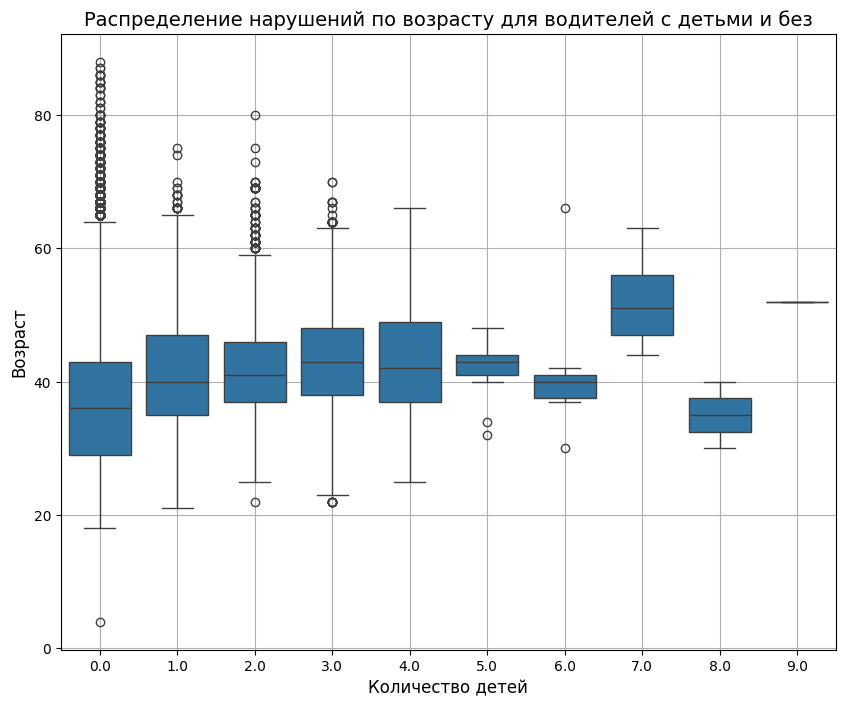

In [226]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='children_cnt', y='age', data=data)
plt.title("Распределение нарушений по возрасту для водителей с детьми и без", fontsize=14)
plt.xlabel("Количество детей", fontsize=12)
plt.ylabel("Возраст", fontsize=12)
plt.grid(True)
plt.show()

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97299 entries, 0 to 97306
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     97299 non-null  object 
 1   offenceshortstatement      97299 non-null  object 
 2   offencedate                97299 non-null  object 
 3   offencetime                97299 non-null  object 
 4   engine_type                97299 non-null  float64
 5   engine_power               97298 non-null  float64
 6   auto_mark                  97299 non-null  object 
 7   auto_year                  97298 non-null  float64
 8   auto_model                 97299 non-null  object 
 9   color                      97299 non-null  object 
 10  gear_type                  97299 non-null  object 
 11  car_price                  90861 non-null  float64
 12  gender_cd                  97175 non-null  object 
 13  age                        97291 non-null  float64


In [50]:
no_children['log_car_price'] = np.log(no_children['car_price'])
one_or_more_children['log_car_price'] = np.log(one_or_more_children['car_price'])

<ipython-input-50-bacb23ff4005>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_children['log_car_price'] = np.log(no_children['car_price'])
<ipython-input-50-bacb23ff4005>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_or_more_children['log_car_price'] = np.log(one_or_more_children['car_price'])


In [132]:
group_no_children = data[data['children_cnt'] == 0]['car_price']
group_one_or_more_children = data[data['children_cnt'] > 0]['car_price']

In [144]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,gear_type,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,Автоматическая,712.0,True,23.0,DILW,0.0,MGR,80.0,Среда,False
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,Механическая,162.0,True,19.0,WID,0.0,AGR,45.0,Понедельник,False
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,Автоматическая,2601.0,True,43.0,WID,0.0,AGR,500.0,Пятница,True
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,Механическая,410.0,True,27.0,DILW,0.0,ACD,35.0,Четверг,False
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,Автоматическая,617.0,False,42.0,DIV,0.0,GRD,50.0,Воскресенье,True


In [122]:
print(f"Тип данных no_children: {type(no_children)}")
print(f"Тип данных one_or_more_children: {type(one_or_more_children)}")


Тип данных no_children: <class 'pandas.core.frame.DataFrame'>
Тип данных one_or_more_children: <class 'pandas.core.frame.DataFrame'>


In [188]:
print(data.keys())

Index(['region', 'offenceshortstatement', 'offencedate', 'offencetime',
       'engine_type', 'engine_power', 'auto_mark', 'auto_year', 'auto_model',
       'color', 'gear_type', 'car_price', 'gender_cd', 'age',
       'marital_status_cd', 'children_cnt', 'education_level_cd',
       'person_monthly_income_amt', 'day_of_week', 'public_holiday',
       'age_group'],
      dtype='object')


In [248]:
age_pdd = filtered_data.groupby(['age', 'children_cnt']).count()['region'].reset_index().rename(columns={'region': 'count_pdd'})

In [235]:
print(age_pdd)

     age  count_pdd
0   18.0        267
1   19.0        837
2   20.0       1192
3   21.0       1518
4   22.0       1838
..   ...        ...
66  84.0          4
67  85.0          4
68  86.0          5
69  87.0          2
70  88.0          1

[71 rows x 2 columns]


In [231]:
filtered_data = data[data['age'] >= 18]

In [168]:
children_pdd = data.groupby('children_cnt').size().reset_index(name='count_pdd')

In [172]:
group_0 = data[data['children_cnt'] == 0].groupby('children_cnt').size().reset_index(name='count_pdd')
group_1plus = data[data['children_cnt'] >= 1].groupby('children_cnt').size().reset_index(name='count_pdd')

In [228]:
group_0 = data[data['children_cnt'] == 0]
group_1plus = data[data['children_cnt'] >= 1]

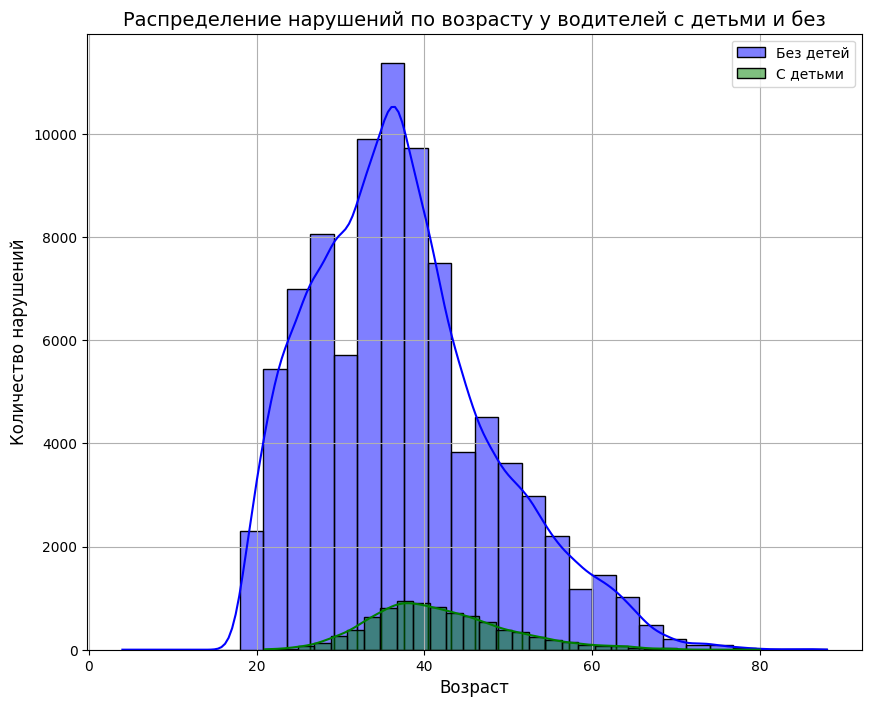

In [229]:
plt.figure(figsize=(10, 8))
sns.histplot(group_0['age'], color='blue', label='Без детей', kde=True, bins=30)
sns.histplot(group_1plus['age'], color='green', label='С детьми', kde=True, bins=30)
plt.title("Распределение нарушений по возрасту у водителей с детьми и без", fontsize=14)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Количество нарушений", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-239-ccf0d079b514>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='children_cnt', y='age', data=filtered_data, palette="muted")


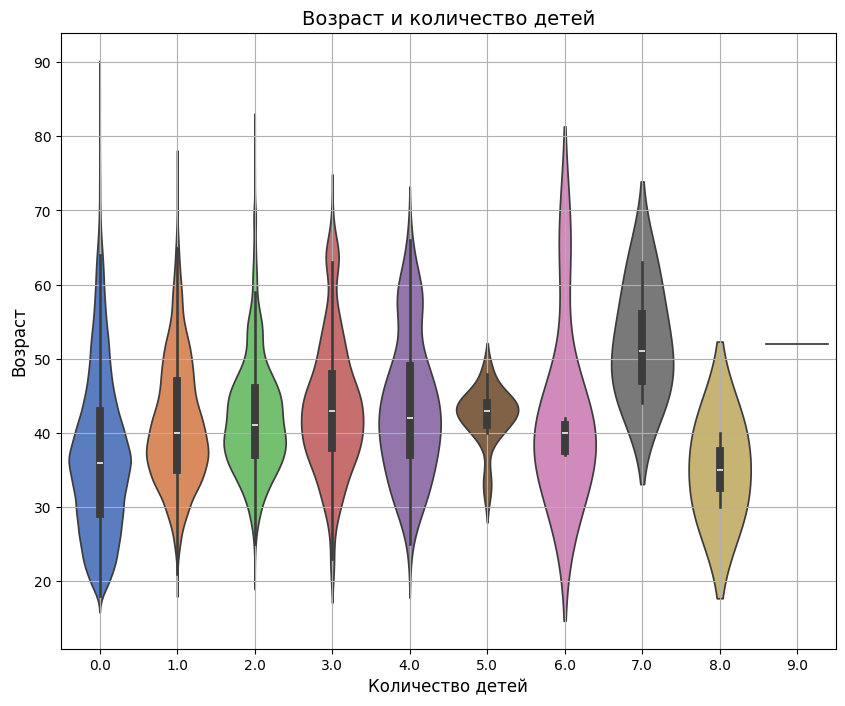

In [239]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='children_cnt', y='age', data=filtered_data, palette="muted")
plt.title("Возраст и количество детей", fontsize=14)
plt.xlabel("Количество детей", fontsize=12)
plt.ylabel("Возраст", fontsize=12)
plt.grid(True)
plt.show()

In [240]:
driver_offences = filtered_data.groupby(['age', 'children_cnt']).size().reset_index(name='offence_count')

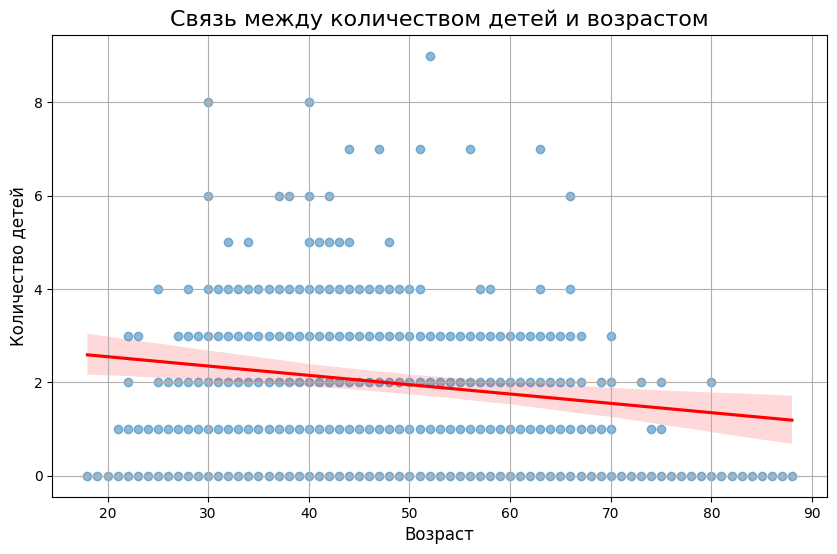

In [244]:
plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='children_cnt', data=driver_offences, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Связь между количеством детей и возрастом", fontsize=16)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Количество детей", fontsize=12)
plt.grid(True)
plt.show()


<ipython-input-245-5eb51a4ea525>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='children_cnt', y='offence_count', data=driver_offences, estimator=sum, palette='Blues')


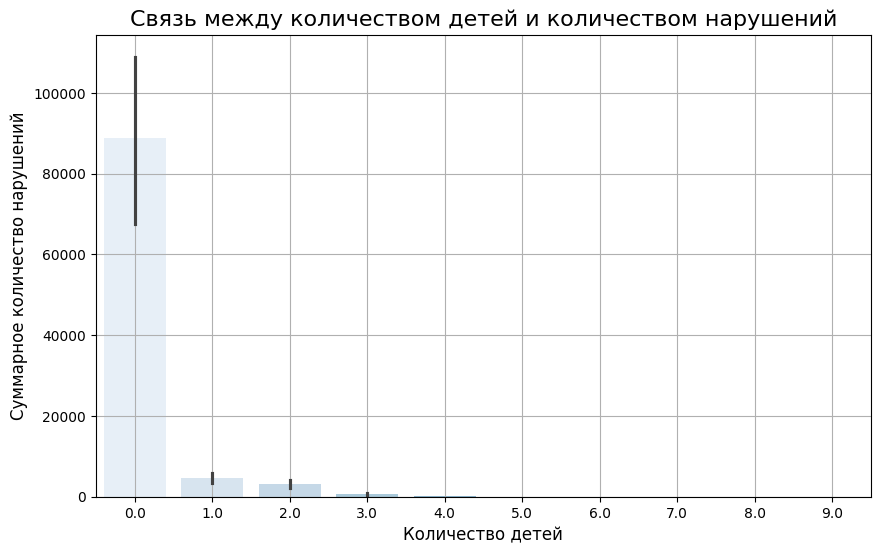

In [245]:
plt.figure(figsize=(10, 6))
sns.barplot(x='children_cnt', y='offence_count', data=driver_offences, estimator=sum, palette='Blues')
plt.title("Связь между количеством детей и количеством нарушений", fontsize=16)
plt.xlabel("Количество детей", fontsize=12)
plt.ylabel("Суммарное количество нарушений", fontsize=12)
plt.grid(True)
plt.show()


<ipython-input-246-9708414a0829>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='age', y='offence_count', data=driver_offences, ci=None, marker='o', color='purple')


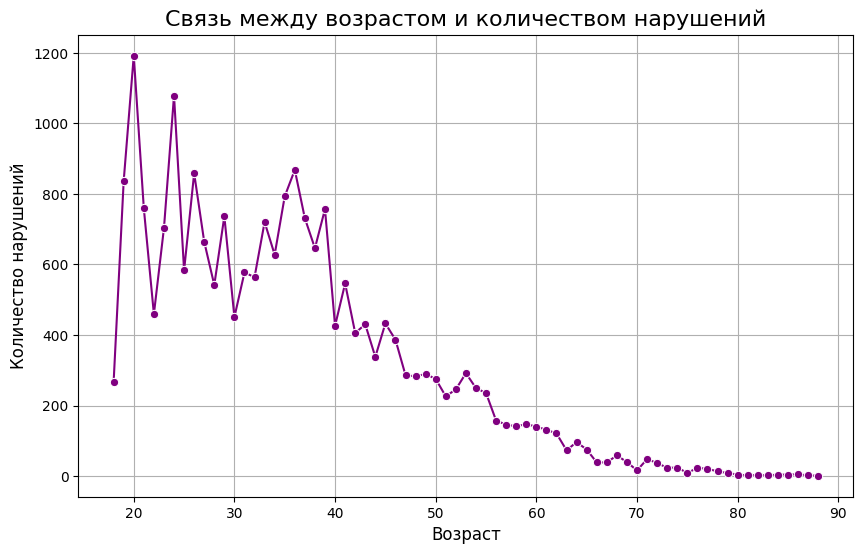

In [246]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='age', y='offence_count', data=driver_offences, ci=None, marker='o', color='purple')
plt.title("Связь между возрастом и количеством нарушений", fontsize=16)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Количество нарушений", fontsize=12)
plt.grid(True)
plt.show()


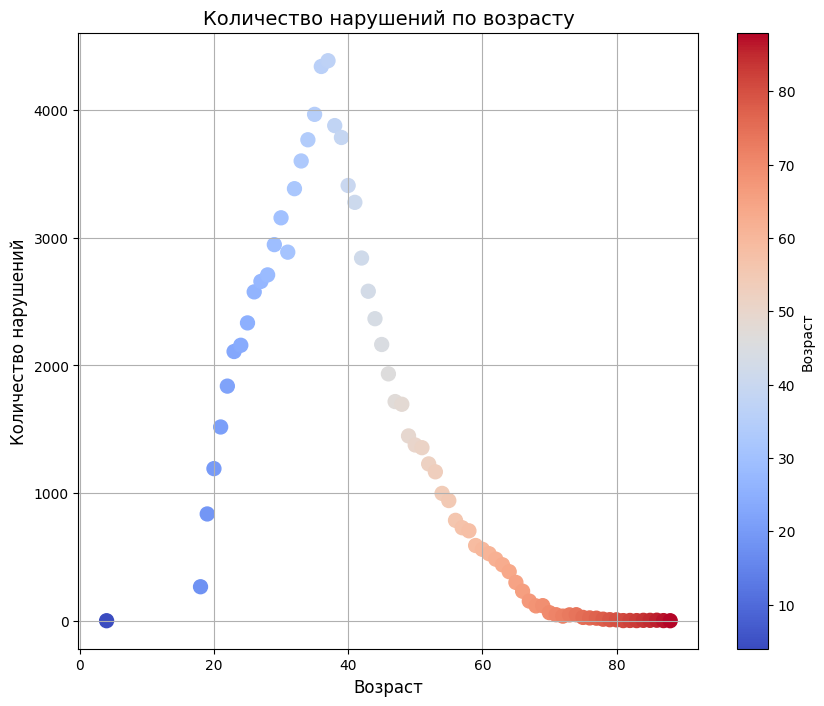

In [225]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(age_pdd['age'], age_pdd['count_pdd'], c=age_pdd['age'], cmap='coolwarm', s=100)
plt.title("Количество нарушений по возрасту", fontsize=14)
plt.xlabel("Возраст", fontsize=12)
plt.ylabel("Количество нарушений", fontsize=12)
plt.grid(True)
plt.colorbar(scatter, label="Возраст")
plt.show()

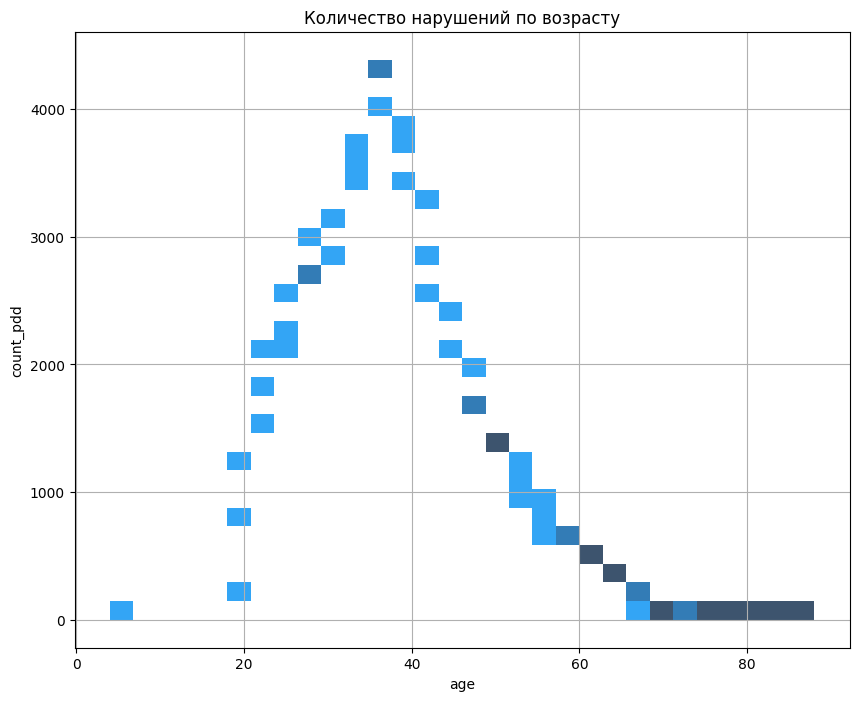

In [221]:
plt.figure(figsize=(10, 8))
sns.histplot(age_pdd, x='age', y='count_pdd', bins=30)
plt.title("Количество нарушений по возрасту")
plt.grid()
plt.show()


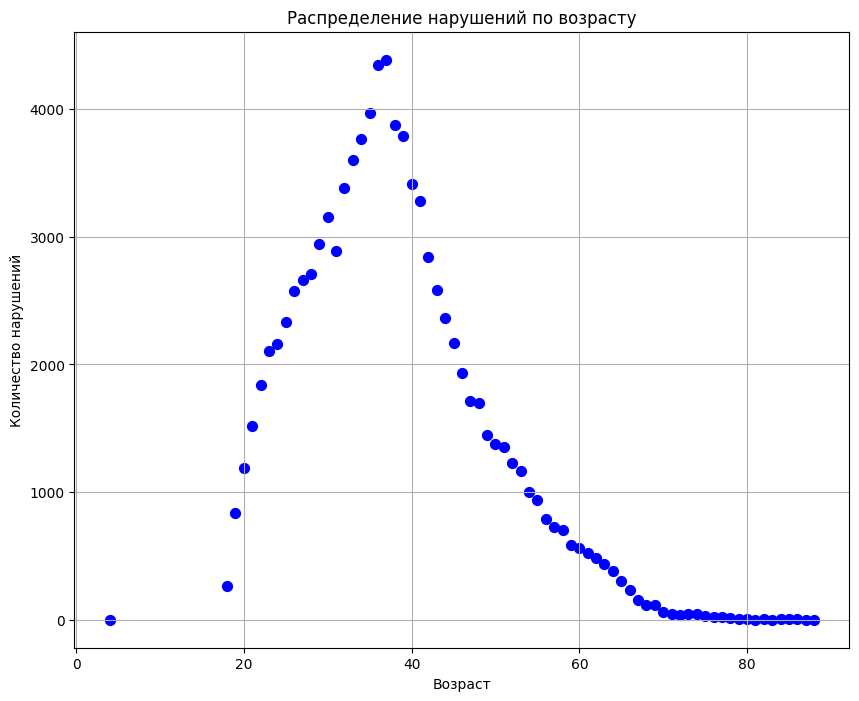

In [222]:
plt.figure(figsize=(10, 8))
plt.scatter(age_pdd['age'], age_pdd['count_pdd'], c='blue', s=50)
plt.title("Распределение нарушений по возрасту")
plt.xlabel("Возраст")
plt.ylabel("Количество нарушений")
plt.grid()
plt.show()


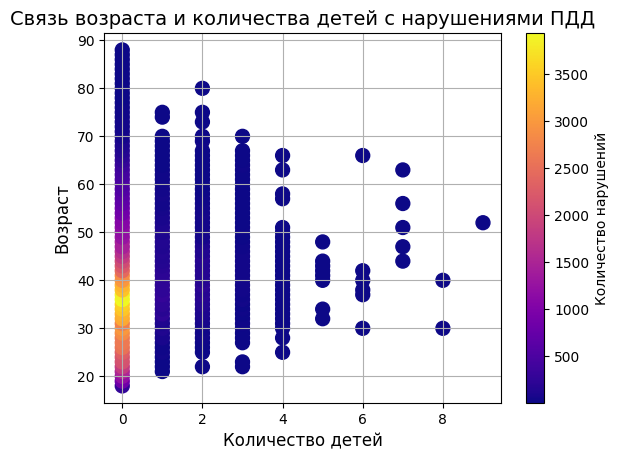

In [255]:
scatter = plt.scatter(age_pdd['children_cnt'], age_pdd['age'],
                      c=age_pdd['count_pdd'], cmap='plasma', s=100)

plt.title("Связь возраста и количества детей с нарушениями ПДД", fontsize=14)
plt.xlabel("Количество детей", fontsize=12)
plt.ylabel("Возраст", fontsize=12)
plt.colorbar(scatter, label="Количество нарушений")
plt.grid(True)
plt.show()

In [234]:

if len(age_pdd) >= 3:
    shapiro_age = stats.shapiro(age_pdd['count_pdd'])
else:
    shapiro_age = "Not enough observations"

print(f'Результаты теста Шапиро: {shapiro_age}')


Результаты теста Шапиро: ShapiroResult(statistic=0.8717222723993946, pvalue=3.060379536366046e-06)


In [173]:
print(group_0)
print(group_1plus)

   children_cnt  count_pdd
0           0.0      88726
   children_cnt  count_pdd
0           1.0       4612
1           2.0       3110
2           3.0        704
3           4.0        111
4           5.0         21
5           6.0          7
6           7.0          5
7           8.0          2
8           9.0          1


In [174]:
if len(group_0) >= 3:
    shapiro_0 = stats.shapiro(group_0['count_pdd'])
else:
    shapiro_0 = "Group 0 has less than 3 observations"

if len(group_1plus) >= 3:
    shapiro_1plus = stats.shapiro(group_1plus['count_pdd'])
else:
    shapiro_1plus = "Group 1+ has less than 3 observations"

print(f'Shapiro-Wilk Test Results:\nGroup 0: {shapiro_0}\nGroup 1+: {shapiro_1plus}')

Shapiro-Wilk Test Results:
Group 0: Group 0 has less than 3 observations
Group 1+: ShapiroResult(statistic=0.6434097331331217, pvalue=0.00030897314120424815)


In [189]:
group_age_18_35 = data[(data['age'] >= 18) & (data['age'] <= 35)]
group_age_35_plus = data[data['age'] > 35]
data['age_group'] = pd.cut(data['age'], bins=[17, 35, float('inf')], labels=['18-35', '35+'])

<ipython-input-189-6baf485ffce4>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_age_group = data.groupby('age_group').agg({'count_pdd': 'sum'}).reset_index()


In [190]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,...,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday,age_group,count_pdd
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,...,True,23.0,DILW,0.0,MGR,80.0,Среда,False,18-24,1
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,...,True,19.0,WID,0.0,AGR,45.0,Понедельник,False,18-24,1
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,...,True,43.0,WID,0.0,AGR,500.0,Пятница,True,35-44,1
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,...,True,27.0,DILW,0.0,ACD,35.0,Четверг,False,25-34,1
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,...,False,42.0,DIV,0.0,GRD,50.0,Воскресенье,True,35-44,1


In [191]:
shapiro_results = {}

for age_group in count_by_age_group['age_group']:
    group_data = data[data['age_group'] == age_group]
    if len(group_data) >= 3:
        shapiro_results[age_group] = stats.shapiro(group_data['count_pdd'])
    else:
        shapiro_results[age_group] = f"Group {age_group} has less than 3 observations"

# Вывод результатов теста на нормальность
for age_group, result in shapiro_results.items():
    print(f'Shapiro-Wilk Test Results for Age Group {age_group}: {result}')

Shapiro-Wilk Test Results for Age Group 18-24: ShapiroResult(statistic=1.0, pvalue=1.0)
Shapiro-Wilk Test Results for Age Group 25-34: ShapiroResult(statistic=1.0, pvalue=1.0)
Shapiro-Wilk Test Results for Age Group 35-44: ShapiroResult(statistic=1.0, pvalue=1.0)
Shapiro-Wilk Test Results for Age Group 45+: ShapiroResult(statistic=1.0, pvalue=1.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9919.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30017.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34830.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro

In [177]:
mannwhitney_result = stats.mannwhitneyu(group_0['count_pdd'], group_1plus['count_pdd'])
print(f'Mann-Whitney U-test result: {mannwhitney_result}')


Mann-Whitney U-test result: MannwhitneyuResult(statistic=9.0, pvalue=0.2)


In [178]:
group_2plus = data[data['children_cnt'] >= 2].groupby('children_cnt').size().reset_index(name='count_pdd')

kruskal_result = stats.kruskal(group_0['count_pdd'], group_1plus['count_pdd'], group_2plus['count_pdd'])
print(f'Kruskal-Wallis test result: {kruskal_result}')


Kruskal-Wallis test result: KruskalResult(statistic=2.840212741357384, pvalue=0.24168830698042465)


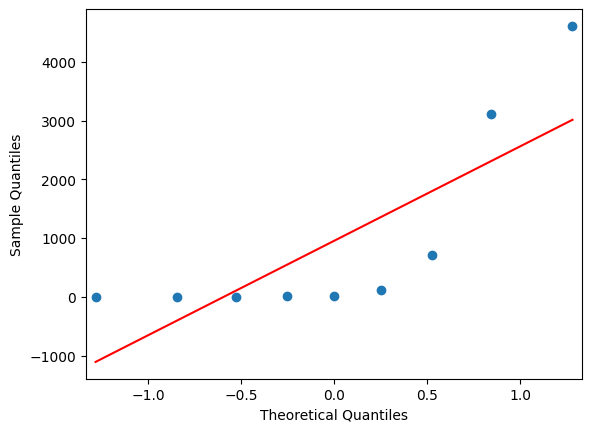

In [179]:
sm.qqplot(group_1plus['count_pdd'], line='s')
plt.show()


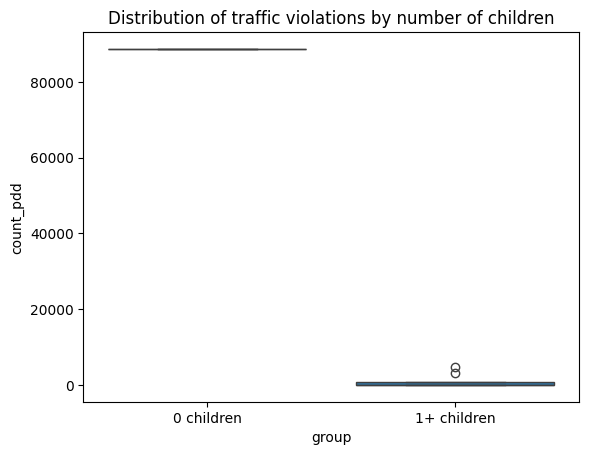

In [176]:

combined_data = pd.concat([group_0.assign(group='0 children'), group_1plus.assign(group='1+ children')])

sns.boxplot(x='group', y='count_pdd', data=combined_data)
plt.title('Distribution of traffic violations by number of children')
plt.show()

In [148]:
ks_stat_0_1, p_value_0_1 = ks_2samp(group_0_counts['count_pdd'], group_1_counts['count_pdd'])
ks_stat_0_2, p_value_0_2 = ks_2samp(group_0_counts['count_pdd'], group_2_plus_counts['count_pdd'])
ks_stat_1_2, p_value_1_2 = ks_2samp(group_1_counts['count_pdd'], group_2_plus_counts['count_pdd'])

anova_stat, anova_p_value = f_oneway(group_0_counts['count_pdd'], group_1_counts['count_pdd'], group_2_plus_counts['count_pdd'])

<Axes: xlabel='log_car_price', ylabel='Density'>

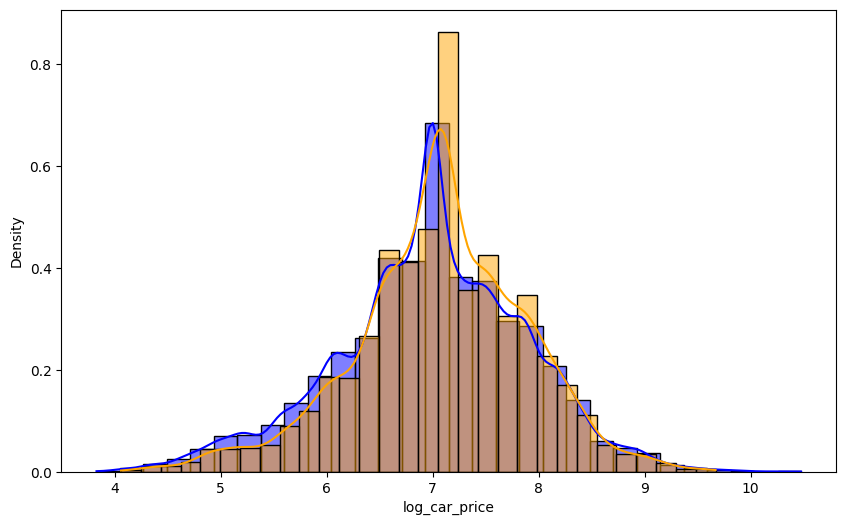

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(no_children['log_car_price'], color='blue', label='Без детей', kde=True, stat='density', bins=30)
sns.histplot(one_or_more_children['log_car_price'], color='orange', label='С детьми', kde=True, stat='density', bins=30)

In [133]:
car_price_no_children = pd.Series(no_children['car_price'])
car_price_one_or_more_children = pd.Series(one_or_more_children['car_price'])

In [124]:
avg_log_price_no_children = no_children['log_car_price'].mean()
avg_log_price_one_or_more_children = one_or_more_children['log_car_price'].mean()

KeyError: 'log_car_price'

In [134]:
avg_price_no_children = no_children['car_price'].mean()
avg_price_one_or_more_children = one_or_more_children['car_price'].mean()

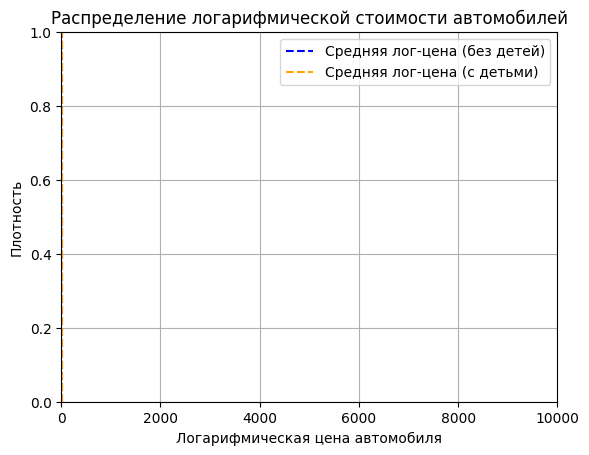

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(no_children['car_price'], color='blue', label='Без детей', kde=True, stat='density', bins=30)
sns.histplot(one_or_more_children['car_price'], color='orange', label='С детьми', kde=True, stat='density', bins=30)
plt.axvline(avg_price_no_children, color='blue', linestyle='--', label='Средняя цена (без детей)')
plt.axvline(avg_price_one_or_more_children, color='orange', linestyle='--', label='Средняя цена (с детьми)')
plt.legend()
plt.title('Распределение стоимости автомобилей')
plt.xlabel('Цена автомобиля')
plt.ylabel('Плотность')
plt.xlim(0, 10000)
plt.grid()
plt.show()

In [135]:
correlation = data[['children_cnt', 'car_price']].corr()
print(correlation)

              children_cnt  car_price
children_cnt      1.000000   0.006899
car_price         0.006899   1.000000


In [49]:
data.isnull(). Sum()

AttributeError: 'DataFrame' object has no attribute 'Sum'

In [136]:
no_children['car_price'].fillna(no_children['car_price'].median(), inplace=True)
one_or_more_children['car_price'].fillna(one_or_more_children['car_price'].median(), inplace=True)



<ipython-input-136-99db32165874>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_children['car_price'].fillna(no_children['car_price'].median(), inplace=True)
<ipython-input-136-99db32165874>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_or_more_children['car_price'].fillna(one_or_more_children['car_price'].median(), inplace=True)


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97299 entries, 0 to 97306
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     97299 non-null  object 
 1   offenceshortstatement      97299 non-null  object 
 2   offencedate                97299 non-null  object 
 3   offencetime                97299 non-null  object 
 4   engine_type                97299 non-null  float64
 5   engine_power               97298 non-null  float64
 6   auto_mark                  97299 non-null  object 
 7   auto_year                  97298 non-null  float64
 8   auto_model                 97299 non-null  object 
 9   color                      97299 non-null  object 
 10  gear_type                  97299 non-null  object 
 11  car_price                  90861 non-null  float64
 12  gender_cd                  97175 non-null  object 
 13  age                        97291 non-null  float64


In [128]:
data.head()

,region,offenceshortstatement,offencedate,offencetime,engine_type,engine_power,auto_mark,auto_year,auto_model,color,gear_type,car_price,gender_cd,age,marital_status_cd,children_cnt,education_level_cd,person_monthly_income_amt,day_of_week,public_holiday
0,Москва,Движение по обочине,2024-05-15,09:52:48,1.8,152.0,SKODA,2011.0,OCTAVIA,ЧЕРНЫЙ,Автоматическая,712.0,True,23.0,DILW,0.0,MGR,80.0,Среда,False
1,Воронежская область,Превышение скорости на 40-60 км/ч,2024-05-13,17:54:58,1.6,73.0,LADA (ВАЗ),2011.0,2107,БЕЛЫЙ,Механическая,162.0,True,19.0,WID,0.0,AGR,45.0,Понедельник,False
2,Севастополь,Превышение скорости на 20-40 км/ч,2024-05-10,00:29:11,2.5,145.0,HYUNDAI,2018.0,GRAND STAREX,СЕРЫЙ,Автоматическая,2601.0,True,43.0,WID,0.0,AGR,500.0,Пятница,True
3,Республика Тыва,Превышение скорости на 20-40 км/ч,2024-05-02,21:44:46,2.0,150.0,MITSUBISHI,2007.0,LANCER,ЧЕРНЫЙ,Механическая,410.0,True,27.0,DILW,0.0,ACD,35.0,Четверг,False
4,Воронежская область,Превышение скорости на 20-40 км/ч,2024-04-28,16:25:51,2.3,155.0,FORD,2004.0,ESCAPE,КРАСНЫЙ,Автоматическая,617.0,False,42.0,DIV,0.0,GRD,50.0,Воскресенье,True


In [77]:
mean_price_no_children = car_price_no_children.mean()
std_price_no_children = car_price_no_children.std()

mean_price_one_or_more_children = car_price_one_or_more_children.mean()
std_price_one_or_more_children = car_price_one_or_more_children.std()

ks_stat_no_children, p_value_no_children = kstest(car_price_no_children, 'norm', args=(mean_price_no_children, std_price_no_children))
ks_stat_one_or_more_children, p_value_one_or_more_children = kstest(car_price_one_or_more_children, 'norm', args=(mean_price_one_or_more_children, std_price_one_or_more_children))

print(f"Результаты для группы без детей (Series):")
print(f"Колмогоров тест: статистика={ks_stat_no_children}, p-value={p_value_no_children}")

print(f"\nРезультаты для группы с одним или более детьми (Series):")
print(f"Колмогоров тест: статистика={ks_stat_one_or_more_children}, p-value={p_value_one_or_more_children}")

Результаты для группы без детей (Series):
Колмогоров тест: статистика=0.17692143387577075, p-value=0.0

Результаты для группы с одним или более детьми (Series):
Колмогоров тест: статистика=0.17049256490516534, p-value=2.4345582244115426e-218


In [79]:
u_statistic, p_value_mannwhitney = mannwhitneyu(car_price_no_children, car_price_one_or_more_children)

if len(car_price_no_children) == len(car_price_one_or_more_children):
    wilcoxon_statistic, p_value_wilcoxon = wilcoxon(car_price_no_children, car_price_one_or_more_children)
else:
    wilcoxon_statistic, p_value_wilcoxon = None, None
    print("Тест Вилкоксона невозможен: количество элементов в выборках не совпадает.")

print(f"Результаты U-теста Манна-Уитни:")
print(f"Статистика: {u_statistic}, p-value: {p_value_mannwhitney}")

if wilcoxon_statistic is not None:
    print(f"\nРезультаты теста Вилкоксона:")
    print(f"Статистика: {wilcoxon_statistic}, p-value: {p_value_wilcoxon}")
else:
    print("Тест Вилкоксона не проведен.")

Тест Вилкоксона невозможен: количество элементов в выборках не совпадает.
Результаты U-теста Манна-Уитни:
Статистика: 356631062.5, p-value: 1.2441173100936259e-21
Тест Вилкоксона не проведен.


In [137]:
f_statistic, p_value_anova = f_oneway(group_no_children, group_one_or_more_children)

correlation_matrix = data[['car_price', 'children_cnt', 'engine_power', 'auto_year', 'age', 'person_monthly_income_amt']].corr()

print(f"Результаты двухвыборочного теста F (ANOVA):")
print(f"Статистика F: {f_statistic}, p-value: {p_value_anova}")

print("\nКорреляционная матрица:")
print(correlation_matrix)

Результаты двухвыборочного теста F (ANOVA):
Статистика F: 2.065218796128251, p-value: 0.1506965148871794

Корреляционная матрица:
                           car_price  children_cnt  engine_power  auto_year  \
car_price                   1.000000      0.006899      0.563978   0.509487   
children_cnt                0.006899      1.000000      0.004077   0.032664   
engine_power                0.563978      0.004077      1.000000   0.156934   
auto_year                   0.509487      0.032664      0.156934   1.000000   
age                         0.102863      0.118173      0.048513   0.131489   
person_monthly_income_amt   0.242156      0.013119      0.197022   0.145414   

                                age  person_monthly_income_amt  
car_price                  0.102863                   0.242156  
children_cnt               0.118173                   0.013119  
engine_power               0.048513                   0.197022  
auto_year                  0.131489                   0.